![Baseball Flights](baseball_flights.png)


To the Office of Transportation at The 22nd Century Sporting League,

After our inaugural 2101 season, The League is looking for ways to optimize our game scheduling process and costs.  We know that transportation logistics are a major variable to consider during scheduling, and as such, we’ve got a few questions for you. 

Our primary areas of focus are surrounding the number of jets that The League needs to own, and the cost of fuel for those flights. If we want The League to enjoy continued success, we'll need to make sure we manage transportation costs.

We’re sharing schedule data for the upcoming 2102 season.  On each row, you’ll find information about which teams are needing to travel to their next set of games, the time the flight will likely depart (based on our estimations of gameplay durations) and the time the flight will likely land. 

Additionally, we're also providing the fuel price that was paid each day during this past 2101 season. The fuel price fluctuates over time, but we're hoping you'll be able to project it to the future to help with the analysis.

## The Data

### team_flights.csv

| Column     | Description              |
|------------|--------------------------|
| `team_name` | Official team name |
| `departure_datetime` | Date and Time (in UTC) when the flight will depart |
| `landing_datetime` | Date and Time (in UTC) when the flight will land |


### fuel_price.csv

| Column     | Description              |
|------------|--------------------------|
| `date` | Date when the fuel price was recorded |
| `fuel_price` | Corresponding fuel price (in $ per gallon) |


### Important Things to Know
- You can assume that the flight's average speed is 500 MPH. (So, as an example, a 2-hour flight would travel 1000 miles)
- You can assume that each team’s jet fills up with fuel equivalent to 1 gallon per mile-of-travel 
- You can assume that the jet is fueled on the day the travel departs (and thus can use the fuel price corresponding to the departure date)

In [23]:
# Import required modules
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

In [24]:
# Explore the data
team_flights = pd.read_csv('./team_flights.csv')
fuel_prices = pd.read_csv('./fuel_prices_2101.csv', index_col='date')

In [25]:
# Some basic data cleaning and pre-processing
team_flights['departure_datetime'] = pd.to_datetime(team_flights['departure_datetime'])
team_flights['landing_datetime']   = pd.to_datetime(team_flights['landing_datetime'])
fuel_prices.index = pd.DatetimeIndex(fuel_prices.index).to_period('D')

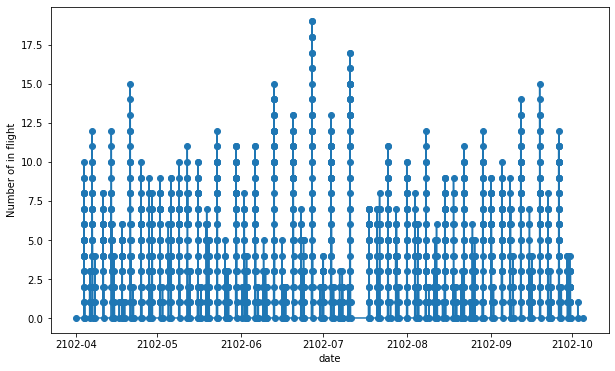

In [26]:
# Visualize the number of teams simultaneously flying
# Building out datetime axis
datetimes = pd.concat([team_flights['departure_datetime'], team_flights['landing_datetime']])

# Preparing for visualization
datetimes_sorted = sorted(list(set(datetimes)))
datetimes_sorted.append(pd.to_datetime('2102-04-01 00:00:00'))
datetimes_sorted.append(pd.to_datetime('2102-10-05 00:00:00'))

# Determining how many flights are mid-air
in_flight_df = pd.DataFrame({'date':sorted(datetimes_sorted), 'in_flight':0})

for index, flight in team_flights.iterrows():
    in_flight_df.loc[(in_flight_df['date']>=flight['departure_datetime']) & 
                     (in_flight_df['date']<flight['landing_datetime']), 'in_flight'] += 1
    
# Visualizing the trends
fig, ax = plt.subplots(figsize=(10,6))
ax.step(in_flight_df['date'], in_flight_df['in_flight'], where='post')
ax.scatter(in_flight_df['date'], in_flight_df['in_flight'])
ax.set_xlabel('date')
ax.set_ylabel('Number of in flight')
plt.show()

In [27]:
# Maximum number of teams simultaneously in flight
max_teams_in_flight = 19

In [38]:
# Project next year's fuel spend
# Projecting fuel prices into 2102
model = SARIMAX(fuel_prices, order = (1, 1, 1), seasonal_order = (1, 0, 0, 7))
results = model.fit()
forecast = results.get_forecast(steps=365)

# Converting projections to a data frame
fuel_prices_forecast = pd.DataFrame(data={'date':forecast.summary_frame().index.to_timestamp(),
                                          'price':forecast.predicted_mean.values})

# Applying fuel prices to flight data
team_flights['departure_datetime'] = pd.to_datetime(team_flights['departure_datetime'])
fuel_prices_forecast['date'] = pd.to_datetime(fuel_prices_forecast['date'])
fuel_prices_forecast.set_index('date', inplace=True)
merged_df = team_flights.join(fuel_prices_forecast, on='departure_datetime', how='left')
merged_df['fuel_cost_total'] = merged_df['price'] * merged_df['travel_distance_miles']
total_fuel_spend_2102_dollars = merged_df['fuel_cost_total'].sum()
total_fuel_spend_2102_dollars

1859801.2927800338